In [4]:
import os
import sys
import regex
import numpy as np
import scipy
from matplotlib import pyplot as plt

debug = False
template_path = './arch'
test_path = './datasets/nodemcu-random-test2'
train_path = './datasets/nodemcu-random-train2'

def butter_filter(trace, order=1, cutoff=0.001, filter_type='low', fs=None):
    """
    Apply butter filter to trace
    """
    b, a = scipy.signal.butter(order, cutoff, btype=filter_type, fs=fs)
    trace_filtered = scipy.signal.filtfilt(b, a, trace)
    return trace_filtered


def plot_trace(trace, title='Trace', xlabel='Time', ylabel='Amplitude'):
    """
    Plot trace
    """
    plt.style.use('_mpl-gallery')
    x = np.linspace(0, len(trace), len(trace))
    fig, ax = plt.subplots()
    fig.set_figwidth(10)
    fig.set_figheight(5)
    ax.plot(x, trace, linewidth=2.0)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    plt.show()


def get_opname(filename):
    """
    Get operation name from filename
    """
    return regex.match(r'nodemcu-(\w+-?\w+)-5600', filename).group(1)

def filter(trace):
    """
    Apply butter filter to trace
    """
    trace_filtered = butter_filter(trace, order=1, cutoff=0.001, filter_type='high', fs=None)
    trace_filtered = np.abs(trace_filtered)
    trace_filtered = butter_filter(trace_filtered, order=1, cutoff=0.001, filter_type='high', fs=None)
    return trace_filtered


# *Zero-mean normalized cross-correlation*

operation $o$
$$\hat{o}=\mathop{\arg \max }_{o\in O} {(\max_t {(c_{b_o,x}(t))})}$$

$$c_{b_{o},x}(t) = \frac{\sum_{i=1}^{n_{b}} (b_o(i)-\overline{b_{o}})(x(i+t)-\overline{x}(t))} {\sqrt{\sum_{i=1}^{n_{b}} (b_o(i)-\overline{b_{o}})^2}\sqrt{\sum_{i=1}^{n_{b}}(x(i+t)-\overline{x}(t))^2}} $$

In [5]:
def corr(b, x, t):
    """
    b: template trace, numpy array
    x: trace of interest, numpy array
    t: time index, int

    output: Zero-mean normalized cross-correlation between b and x[t:t+len(b)].
    Assuming that the length of b is less than the length of x.
    """
    b_offset = b - np.mean(b)
    x_prime = x[t:t+len(b)]
    x_offset = x_prime - np.mean(x_prime)
    return np.sum(b_offset*x_offset) / (np.sqrt(np.sum(b_offset**2)) * np.sqrt(np.sum(x_offset**2)))

def fast_xcorr(trace, ref_trace, prefilter=True, required_corr=-1.0, normalized=True, return_corr=False, return_corr_trace=False):
    """
    Fast normalized cross correlation between 1D signal and a reference signal.
    """
    comp_trace = trace
    comp_ref = ref_trace
    if prefilter:
        comp_trace = butter_filter(trace, 1, 0.02, 'low', None)
        comp_ref = butter_filter(ref_trace, 1, 0.02, 'low', None)

    # Not as precise as doing this on a per-window basis but much faster.
    comp_trace = comp_trace - np.mean(comp_trace)
    comp_ref = comp_ref - np.mean(comp_ref)

    # Correlate it with the ref signal and shift accordingly
    corr = scipy.signal.fftconvolve(comp_trace, comp_ref[::-1], mode="valid")
    if normalized:
        y = np.sqrt(np.sum(np.square(comp_ref)))
        x = np.sum(np.square(comp_trace[0:len(comp_ref)]))

        corr[0] /= np.sqrt(x) * y
        # Sliding update of sum
        for i in range(0, len(corr)-1):
            x -= comp_trace[i] ** 2
            x += comp_trace[i + len(comp_ref)] ** 2
            corr[i + 1] /= np.sqrt(x) * y

    # Get best correlation index and value
    best_index = np.argmax(corr)
    best_corr = max(corr)

    # Debug plot
    if debug:
        plt.figure(figsize=(10, 5))
        plt.plot(corr, label="corr", color='green', alpha=0.5)
        plt.plot(butter_filter(ref_trace, 1, 0.02, 'low', None), label="ref", color='red')
        plt.plot(butter_filter(trace[best_index:], 1, 0.02, 'low', None), label="aligned")
        plt.plot(butter_filter(trace, 1, 0.02, 'low', None), label="original")
        plt.legend()
        plt.show()

    if return_corr_trace:
        return corr

    if return_corr:
        if best_corr < required_corr:
            return None
        else:
            return best_index, best_corr
    else:
        if best_corr < required_corr:
            return None
        else:
            return best_index

def find_trace(trace, template, return_indices=False):
    if len(trace) < len(template):
        return None

    #debug_trace(trace)

    index = fast_xcorr(trace[0:120000], template, normalized=True, prefilter=False)
    if index is None:
        return None

    if return_indices:  # Only return indices (don't cut trace)
        return index, index+len(template)
    else:  # Cut trace and return it
        trace = trace[index:index+len(template)]

        return trace

# Make Templates

1. Make bootstrap templates (manually select) -> archboot
2. Make templates using training dataset -> arch
3. Remove triggers -> archnotigger

## Step 1 skip

In [6]:
# make templates

boot_templates = {}
templates_path = './archboot'
for entry in os.listdir(templates_path):
    if not entry.endswith('.npy'):
        continue
    arch_template = np.load(os.path.join(templates_path, entry))
    arch_template = filter(arch_template)

    op = get_opname(entry).replace('-', '_')
    boot_templates[op] = arch_template
    if debug:
        plot_trace(arch_template, title='Template: '+op)

print(boot_templates.keys())

dict_keys(['aes', 'aes_openssl', 'aes_tiny', 'des_openssl', 'hmacsha1', 'sha1', 'sha1prf', 'sha1transform'])


## Step 2 Load training dataset and create templates

Creating template for: aes
[====================================================================================================] 100%

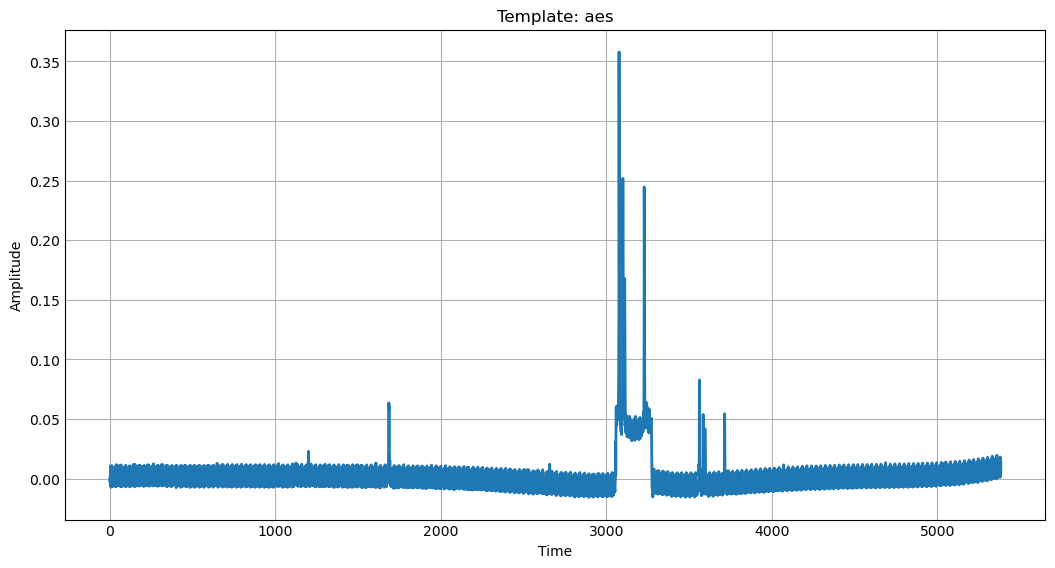

Creating template for: aes_openssl
[====================================================================================================] 100%

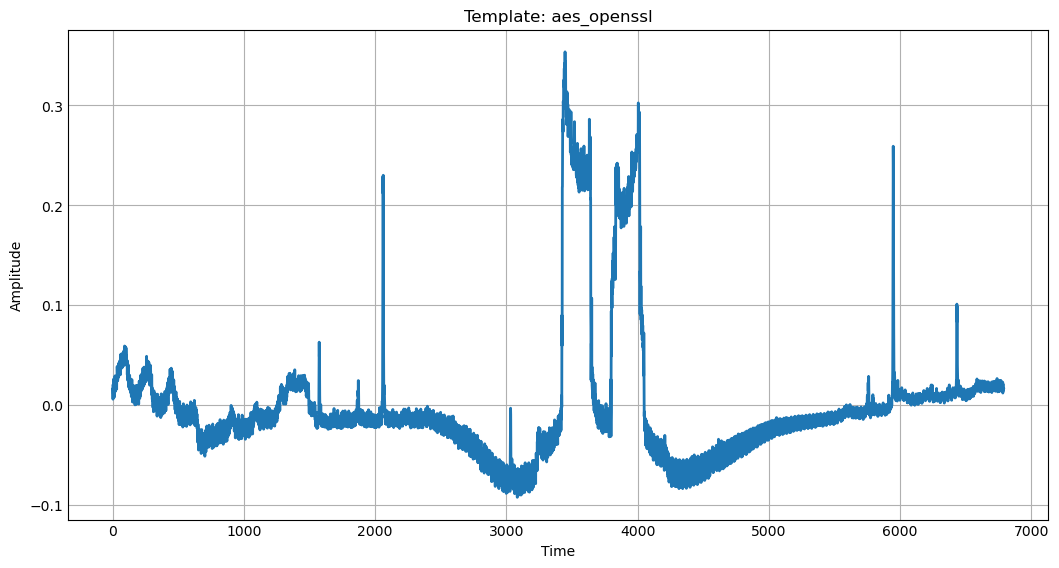

Creating template for: aes_tiny
[====================================================================================================] 100%

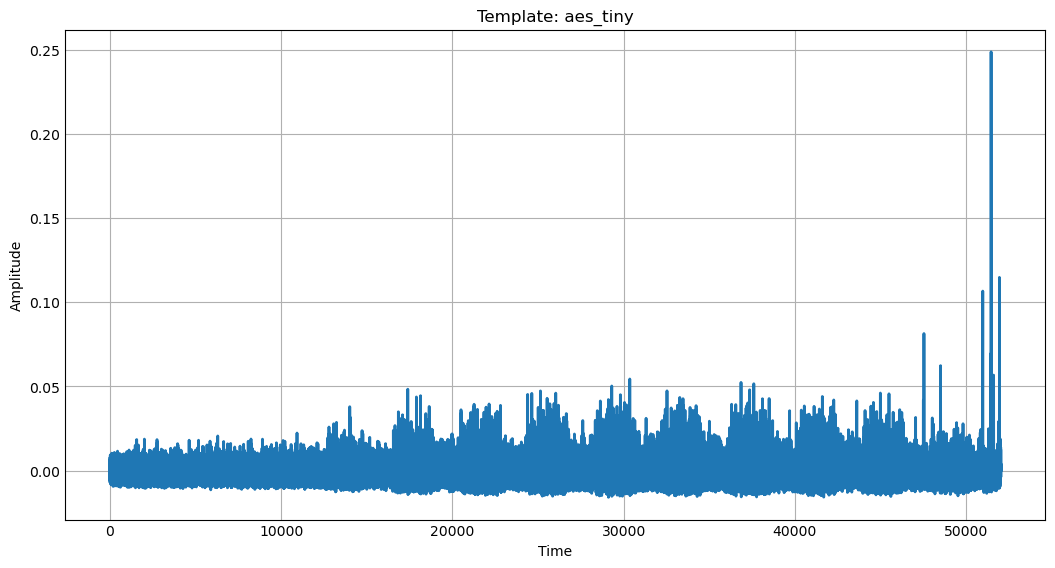

Creating template for: des_openssl
[=====================================                                                               ] 37%

C:\Users\Juncheng\AppData\Local\Temp\ipykernel_23832\593220289.py:35: RuntimeWarning: invalid value encountered in scalar divide
  corr[0] /= np.sqrt(x) * y
C:\Users\Juncheng\AppData\Local\Temp\ipykernel_23832\593220289.py:40: RuntimeWarning: invalid value encountered in scalar divide
  corr[i + 1] /= np.sqrt(x) * y


[====================================================================================================] 100%

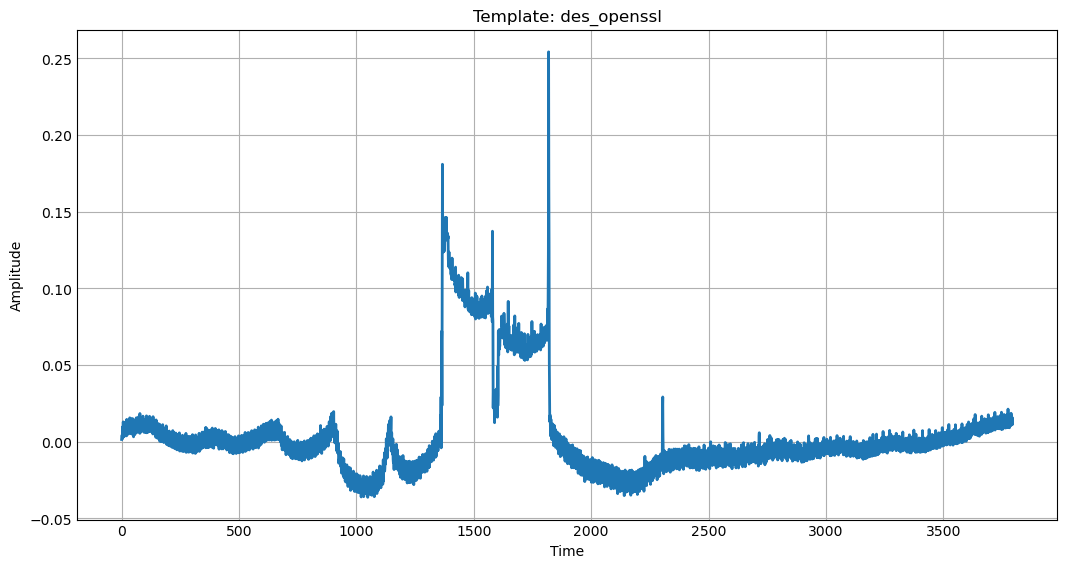

Creating template for: hmacsha1
[====================================================================================================] 100%

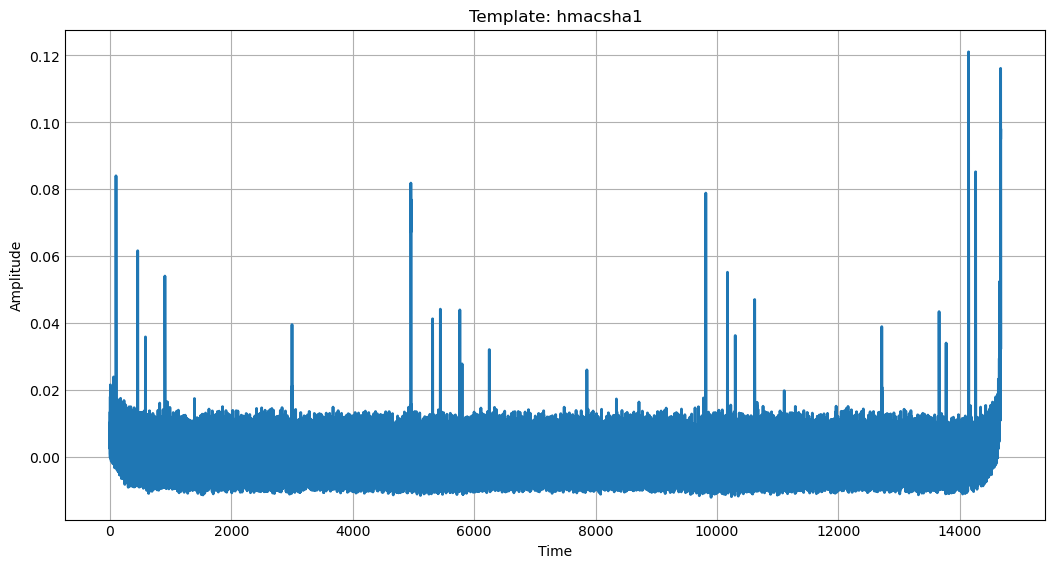

Creating template for: sha1
[====================================================================================================] 100%

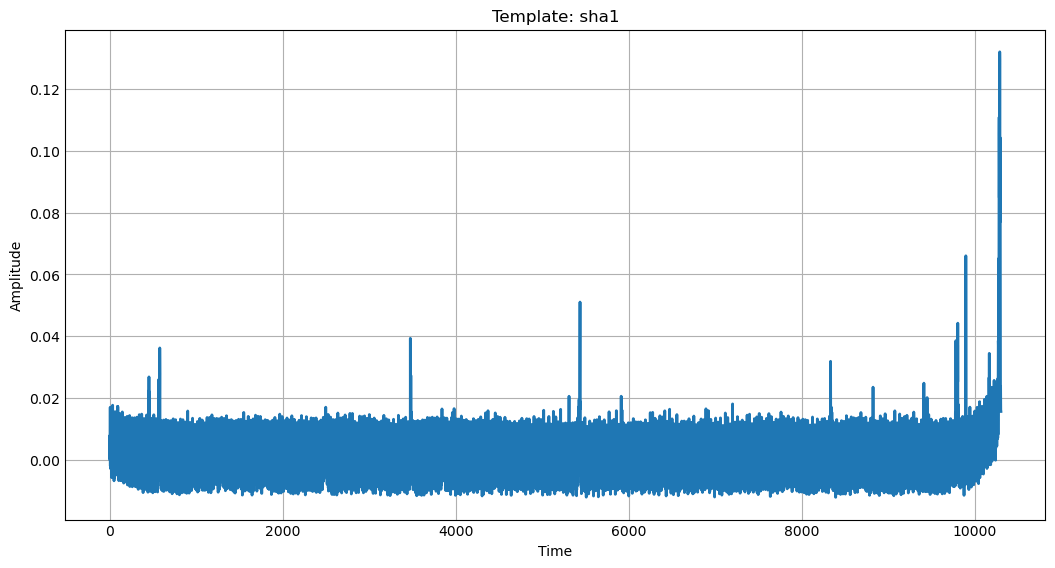

Creating template for: sha1prf
[====================================================================================================] 100%

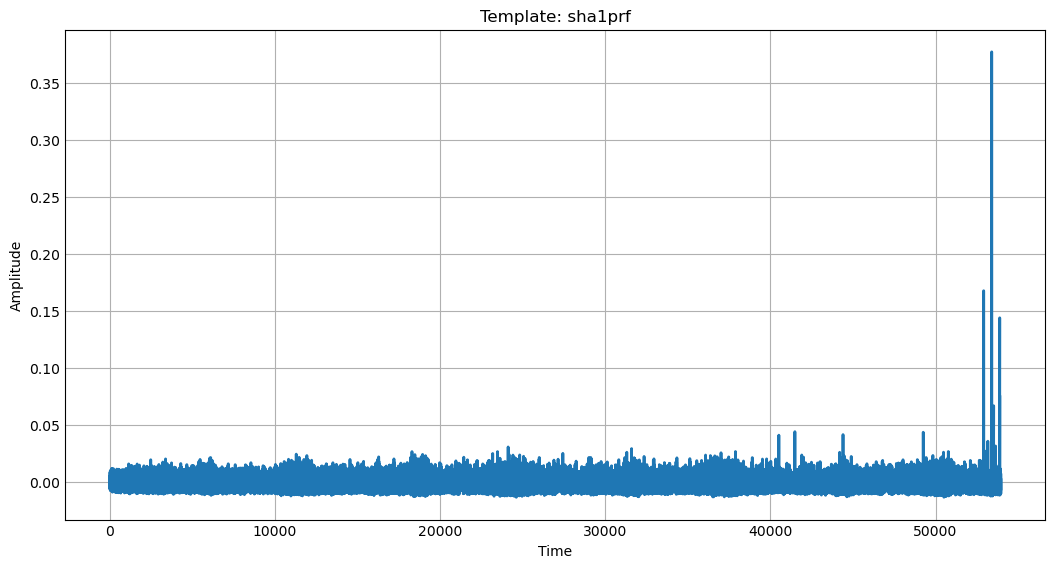

Creating template for: sha1transform
[====================================================================================================] 100%

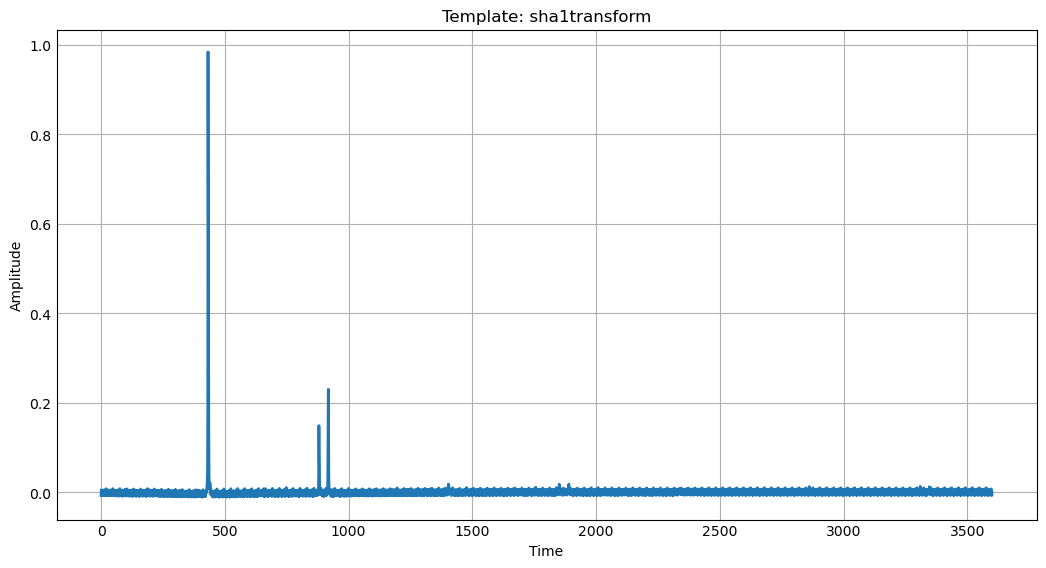

In [8]:
# load training dataset
training_traces = [entry for entry in os.listdir(train_path) if entry.endswith('_traces.npy')]
template_path = './templates'   
if not os.path.exists(template_path):
    os.makedirs(template_path)

# build templates for each categories
for arch_template_op, arch_template in boot_templates.items():
    print('Creating template for:', arch_template_op)
    template = []
    batch_template = []
    if debug:
        plot_trace(arch_template, title='Template: '+ arch_template_op)

    for idx, entry in enumerate(training_traces):
        filename = entry.rpartition('_traces')[0]
        traces = np.load(os.path.join(train_path, entry), allow_pickle=True)
        metadata = np.load(os.path.join(train_path, filename+'_meta.p'), allow_pickle=True)
        for i, trace in enumerate(traces):
            # skip noise traces
            trace_op = metadata[i]['op']
            if trace_op != arch_template_op or len(trace) < len(arch_template):
                continue
            
            trace = filter(trace)
            detected_trace = find_trace(trace, arch_template)
            if detected_trace is not None:
                batch_template.append(detected_trace)
                if len(batch_template) == 20:
                    template.append(np.mean(batch_template, axis=0))
                    batch_template = []
        del traces
        del metadata

        precentage = int((idx+1)/len(training_traces)*100)
        sys.stdout.write('\r')
        sys.stdout.write("[%-100s] %d%%" % ('='*int(precentage), precentage))
        sys.stdout.flush()
    template = np.mean(template, axis=0)
    plot_trace(template, title='Template: '+ arch_template_op)
    np.save(os.path.join(template_path, arch_template_op+'.npy'), template)
    template = []

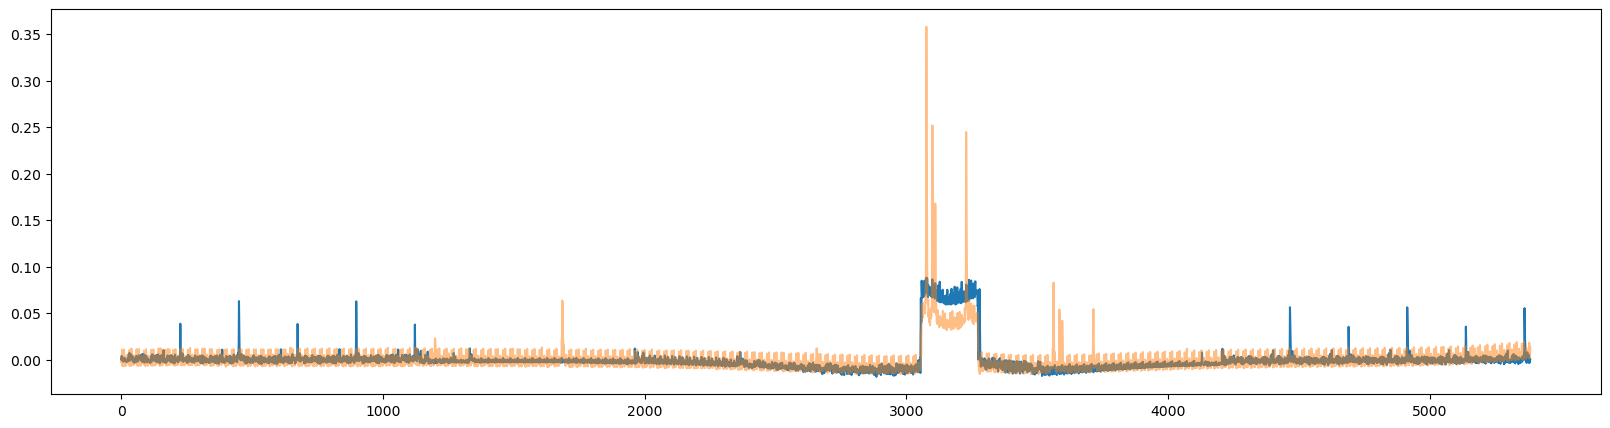

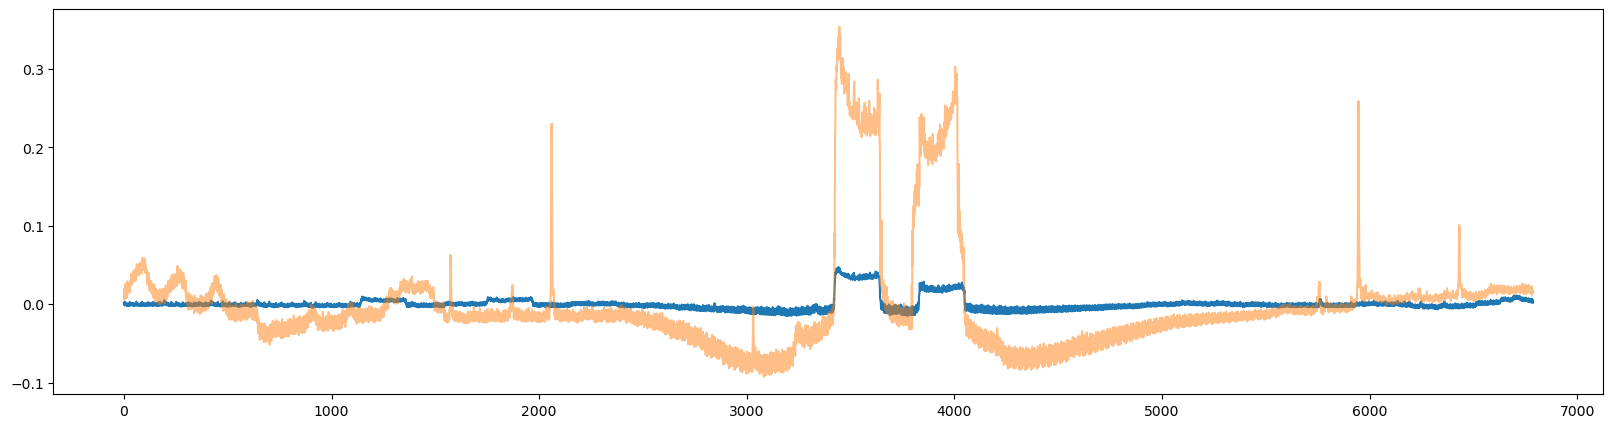

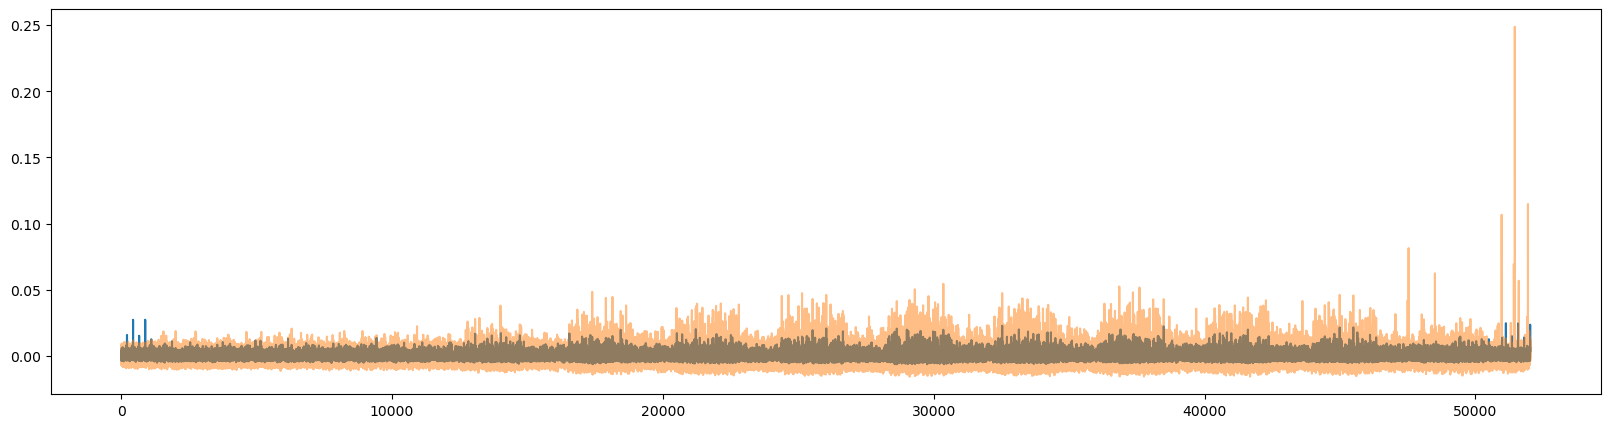

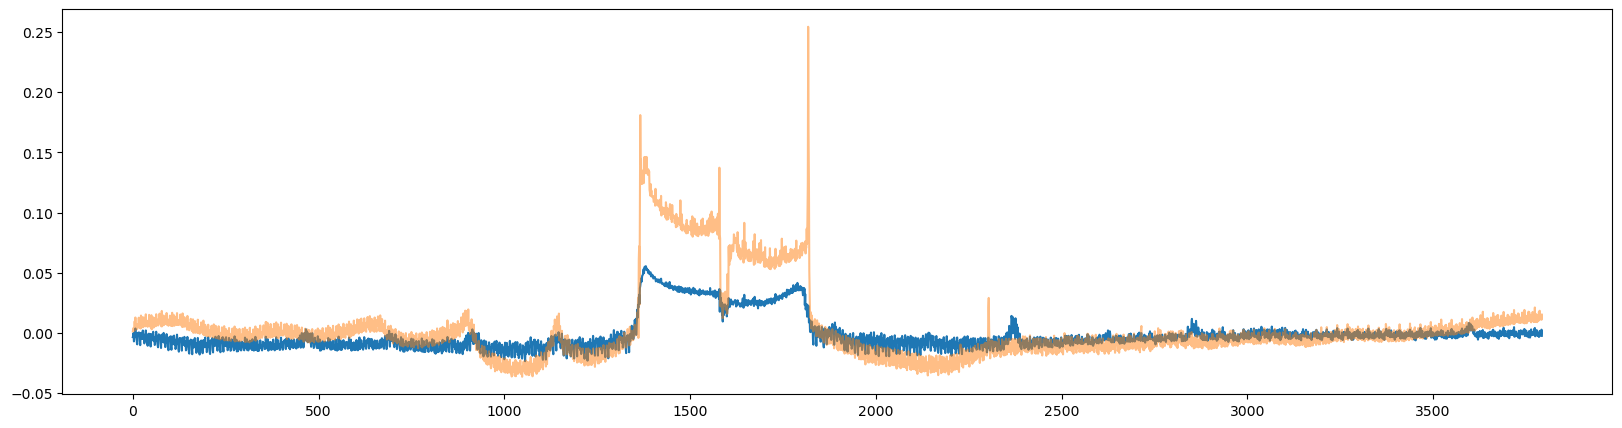

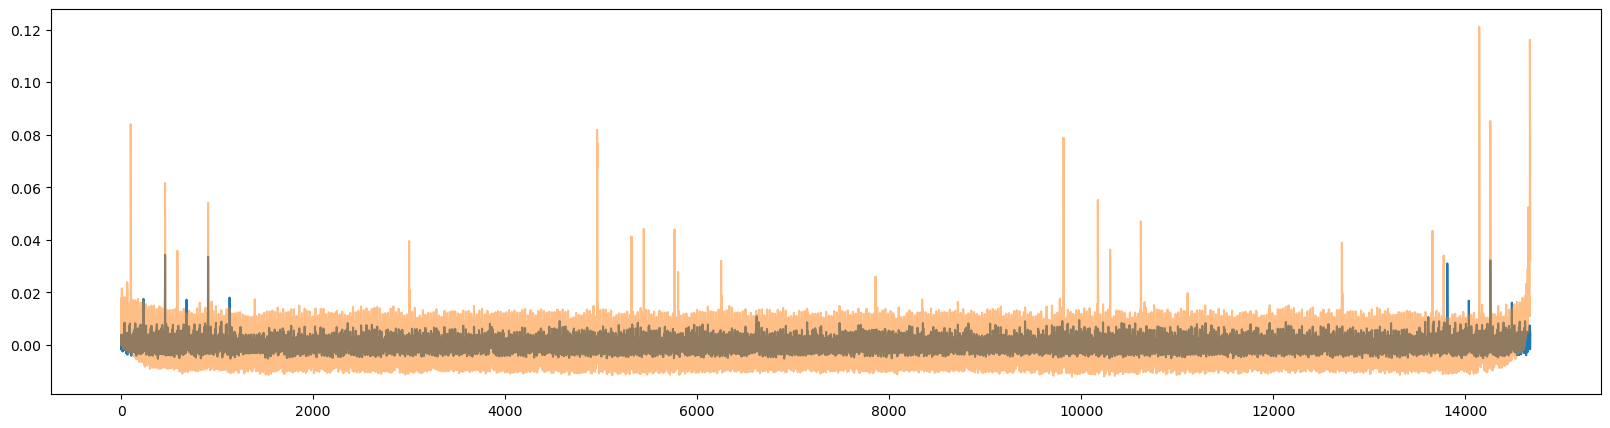

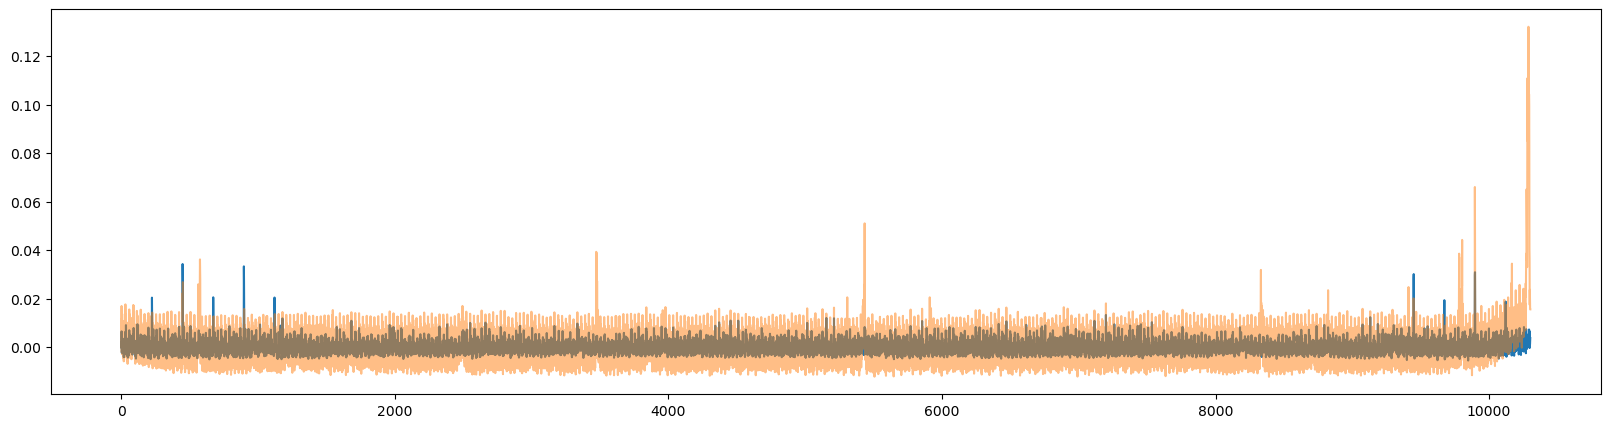

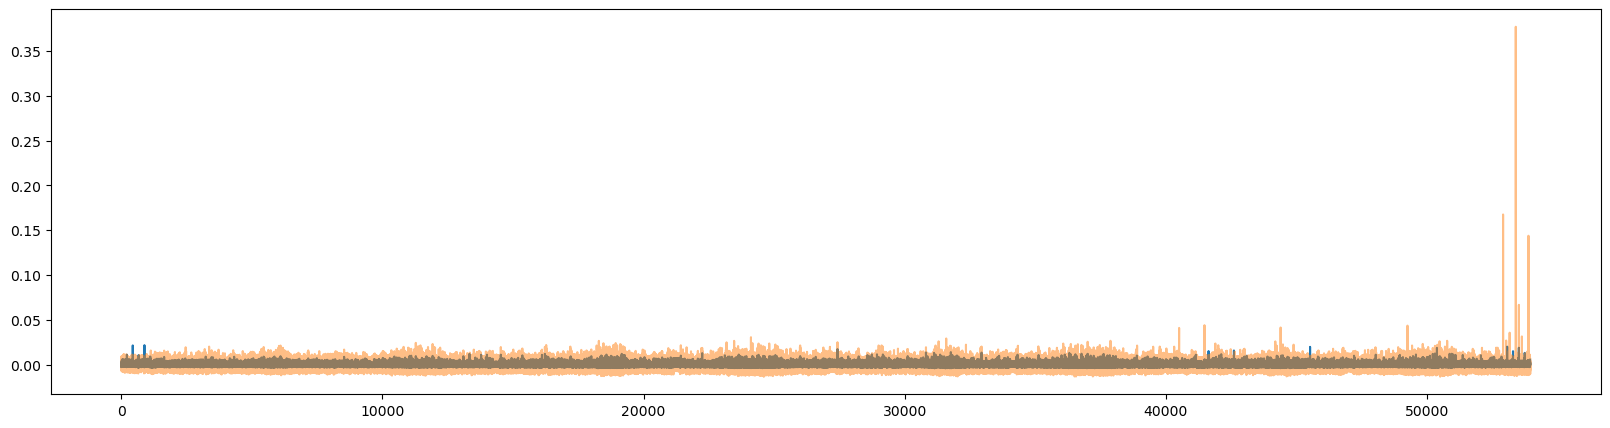

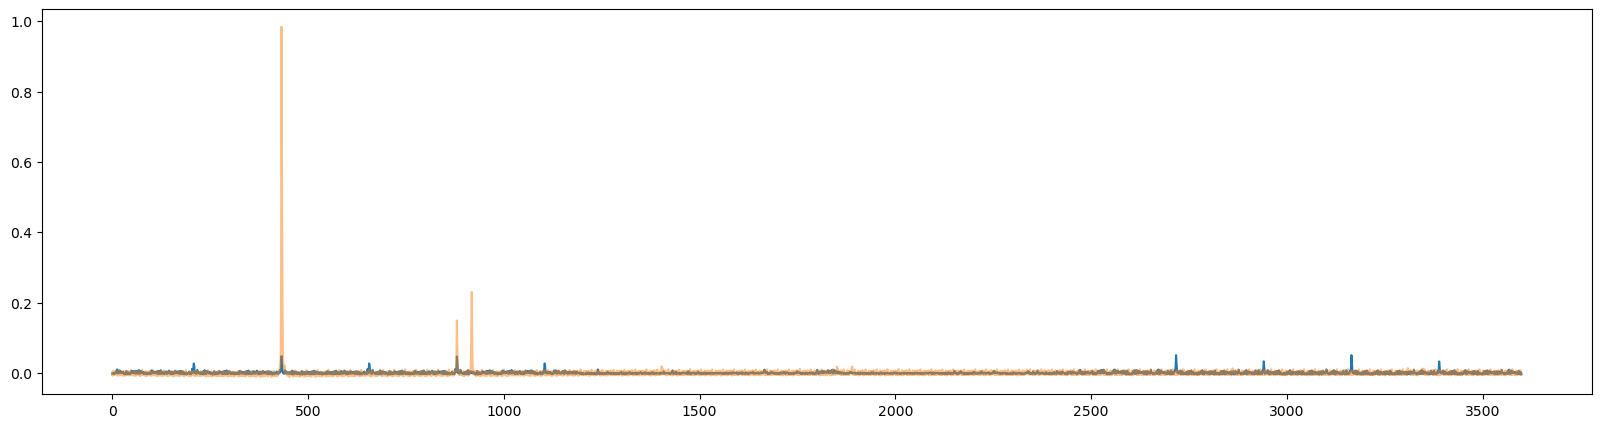

In [18]:
# compare templates

aes_arch_template = np.load('arch/nodemcu-aes-56000000.npy', allow_pickle=True)
aes_my_template = np.load('templates/aes.npy', allow_pickle=True)

files = os.listdir('./arch')

# remove trigger
os.makedirs('./templates_notrigger', exist_ok=True)
for entry in files:
    op = get_opname(entry)
    arch_temp = np.load(os.path.join('arch', entry), allow_pickle=True)
    my_temp = np.load(os.path.join('templates', op.replace('-', '_') + '.npy'), allow_pickle=True)
    
    no_trigger = my_temp[1200:-1200]
    np.save(os.path.join('./templates_notrigger', op + '_notrigger.npy'), no_trigger)
    
    plt.figure(figsize=(20, 5))
    plt.plot(arch_temp, label='arch' + op)
    plt.plot(my_temp, label='my' + op, alpha=0.5)
    plt.show()


# plt.figure(figsize=(20, 5))
# plt.plot(aes_arch_template, label='arch', color='red')
# plt.plot(aes_my_template, label='my', alpha=0.5)
# plt.legend()
# plt.show()

# Test
## ZNCC template matching

In [24]:
# load templates
files = os.listdir('./templates_notrigger')
arch_templaes = {}
for entry in files:
    if not entry.endswith('.npy'):
        continue
    template = np.load(os.path.join('./templates_notrigger', entry))
    op = entry.rpartition('_notrigger.npy')[0].replace('-', '_')
    arch_templaes[op] = template
    if debug:
        plot_trace(template, title='Template: '+op)

# load test datasets

test_traces = [entry for entry in os.listdir(test_path) if entry.endswith('_traces.npy')]
print('Test traces:', len(test_traces))

true_label = []
pred_label = []

for idx, entry in enumerate(test_traces):
    filename = entry.rpartition('_traces')[0]
    traces = np.load(os.path.join(test_path, entry), allow_pickle=True)
    metadata = np.load(os.path.join(test_path, filename+'_meta.p'), allow_pickle=True)
    for i, trace in enumerate(traces):
        trace_op = metadata[i]['op']
        if trace_op not in arch_templaes.keys() or len(trace) < 1000:
            continue
        trace = filter(trace)
        
        max_corr = -1
        pred_op = None
        
        for arch_template_op, arch_template in arch_templaes.items():
            if len(trace) < len(arch_template):
                continue
            _, corr = fast_xcorr(trace, arch_template, normalized=True, prefilter=False ,return_corr=True)
            if corr > max_corr:
                max_corr = corr
                pred_op = arch_template_op

        true_label.append(trace_op)
        pred_label.append(pred_op)

    precentage = int((idx+1)/len(test_traces)*100)
    sys.stdout.write('\r')
    sys.stdout.write("[%-100s] %d%%" % ('='*int(precentage), precentage))
    sys.stdout.flush()

print('Test finished\n')

Test traces: 256
[====================================================================================================] 100%Test finished


               precision    recall  f1-score   support

          aes       0.69      0.48      0.56       422
  aes_openssl       0.98      0.75      0.85       482
     aes_tiny       1.00      0.17      0.29       452
  des_openssl       0.60      0.21      0.31       450
     hmacsha1       0.04      0.00      0.00       472
         sha1       0.03      0.01      0.01       462
      sha1prf       1.00      0.12      0.22       476
sha1transform       0.16      0.98      0.28       428

     accuracy                           0.33      3644
    macro avg       0.56      0.34      0.32      3644
 weighted avg       0.57      0.33      0.32      3644

[[201   0   0   0   6  22   0 193]
 [ 42 360   0  62   1   2   0  15]
 [  0   0  77   1   0  15   0 359]
 [ 47   5   0  95  19  56   0 228]
 [  1   0   0   0   1   2   0 468]
 [  1   0   0   0   0   3   0 458]
 [  1   0   0   0   0   9  59 407]
 [  0   1   0   0   0   7   0 420]]


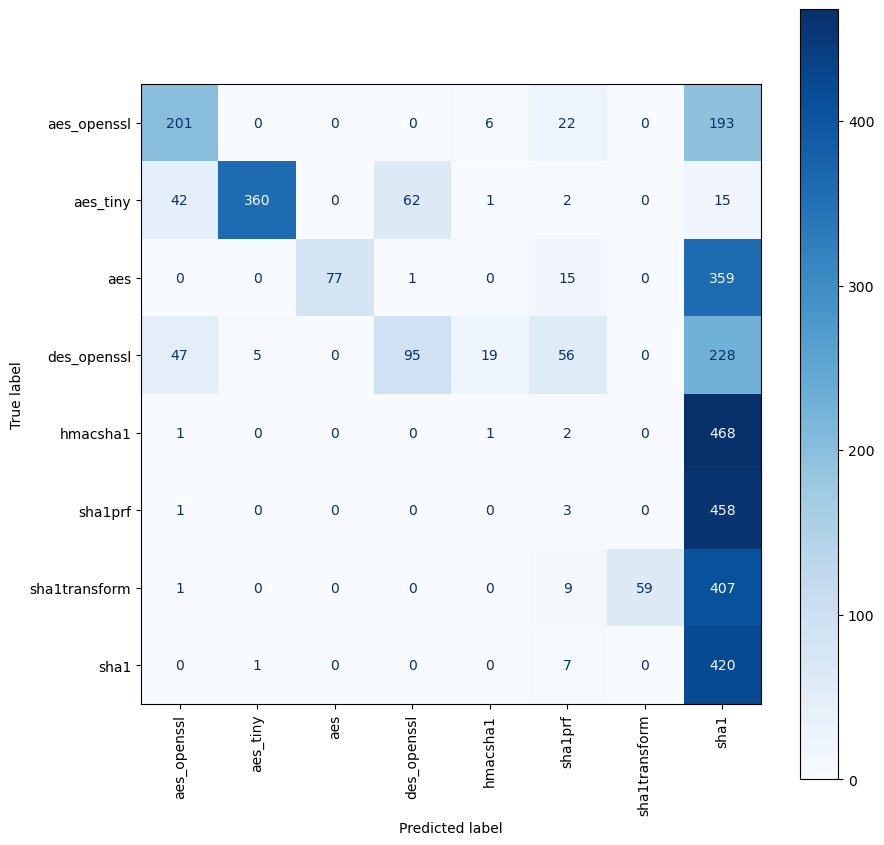

In [25]:

# Show test results
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

assert(len(true_label) == len(pred_label))
print(classification_report(true_label, pred_label))
# Plot confusion matrix
plt.style.use('default')
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
cm = confusion_matrix(true_label, pred_label)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=arch_templaes.keys())
disp.plot(ax=ax, values_format='d', cmap='Blues', xticks_rotation='vertical')
plt.show()